In [1]:
# Importe les librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

<img src='./images/logo-oncfm.png'  width=360px/>

# Détectez des faux billets avec Python

# Sommaire

* [Importation et description des données](#1)
* [Traitement des valeurs manquantes](#2)
    * [Aperçu des données](#2-1)
    * [Mise en place et analyse du modèle](#2-2)
    * [Fiabilité du modèle](#2-3)
    * [Prédiction des valeurs manquantes](#2-4)
* [Analyse descriptive](#3)
    * [Analyse univariée](#3-1)
    * [Analyse bivariée](#3-2)

## Importation et description des données<a id='1'></a>

In [2]:
# Importe le dataset et affiche un aperçu
df_billets = pd.read_csv('./datasets/raw/billets.csv', sep=';')
df_billets.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


In [3]:
# Affiche le type des variables
df_billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [4]:
# Affiche les dimension du dataset
print(
    f'Dimensions du jeu de données :\n'
    f'- {df_billets.shape[0]} enregistrements ;\n'
    f'- {df_billets.shape[1]} variables.'
)

Dimensions du jeu de données :
- 1500 enregistrements ;
- 7 variables.


In [5]:
# Affiche le nombre de valeurs uniques
df_billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [6]:
# Affiche le nombre de valeurs manquantes
df_billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il manque 37 valeurs à « margin_low ». Avant de pouvoir mettre en place notre algorithme de détection, nous devons traiter ces données manquantes.

## Traitement des valeurs manquantes<a id='2'></a>

Plusieurs méthodes existent pour traiter les valeurs manquantes. Dans le cadre de ce projet, c'est la **régression linéaire multiple** qui a été retenue. Le principe consiste à modéliser une variable dépendante (ici « margin_low ») grâce à une combinaison linéaire de variables explicatives (ici « diagonal », « height_left », etc.). Ensuite, grâce aux résultats de cette régression nous allons faire une prédiction des valeurs manquantes de « margin_low ».

Pour construire notre modèle, nos données de départ ne doivent pas contenir de valeur manquantes.

In [7]:
# Crée une copie du DataFrame sans valeurs manquantes
df_billets_sans_na = df_billets.loc[
    ~df_billets.isna().any(axis='columns')].copy()

# Affiche le nombre d'enregistrements et le nombre de valeurs manquantes
print(
    f'Il y a {df_billets_sans_na.shape[0]} enregistrements et '
    f'{df_billets_sans_na.isna().sum().sum()} valeurs manquantes.'
)

Il y a 1463 enregistrements et 0 valeurs manquantes.


### Aperçu des données<a id='2-1'></a>

Première étape : on trace nos données par paires de variables grâce à la fonction ci-dessous. Cette dernière va également nous indiquer les coefficients de corrélation.

In [8]:
def pairplot_correlation(df, hue=None):
    '''
    Trace les paires de variables et affiche les coefficients de corrélation.
    Paramètres :
    - df = DataFrame source ;
    - hue = variable à différencier (couleur) sur le graphique.
    '''
    # Calcule la matrice de corrélation
    corr_matrix = df.select_dtypes(include='number').corr()

    # Définit le nombre de sous-graphiques et la taille du graphique
    fig, axs = plt.subplots(
        corr_matrix.shape[0], corr_matrix.shape[1], 
        figsize=((corr_matrix.shape[0]*1.8), (corr_matrix.shape[1]*1.4))
    )

    # Boucle sur les lignes et colonnes de la matrice de corrélation
    for i, idx in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            # Affiche le nom des variables
            if i == j:
                axs[i, j].text(x=0.5, y=0.5, s=idx, ha='center', va='center',
                               fontweight='bold')
                axs[i, j].xaxis.set_major_locator(ticker.NullLocator())
                axs[i, j].yaxis.set_major_locator(ticker.NullLocator())

            # Affiche les coefficients de corrélation
            elif i < j:
                corr_coeff = corr_matrix.loc[idx, col]
                axs[i, j].text(x=0.5, y=0.5, s=f'corr =\n{corr_coeff:.3}',
                               ha='center', va='center')
                axs[i, j].xaxis.set_major_locator(ticker.NullLocator())
                axs[i, j].yaxis.set_major_locator(ticker.NullLocator())

            # Trace les graphiques
            elif i > j:
                # Trace en fonction de la variable indiquée dans 'hue'
                if hue != None:
                    hue = hue
                    for value in df[hue].unique():
                        axs[i, j].scatter(
                            x=idx, y=col, data=df.loc[df[hue] == value], 
                            marker='.', edgecolors='k', alpha=0.65
                        )
                        axs[i, j].tick_params(axis='both', labelsize=6.5)

                # Trace sans différenciation
                elif hue == None:
                    axs[i, j].scatter(x=idx, y=col, data=df, marker='.',
                                      edgecolors='k', alpha=0.65)
                    axs[i, j].tick_params(axis='both', labelsize=6.5)

    fig.suptitle('Paires de variables et coefficients de corrélation')

    fig.tight_layout()
    # plt.subplots_adjust(right=0.95, top=0.95, wspace=0.45, hspace=0.3)

    plt.show()

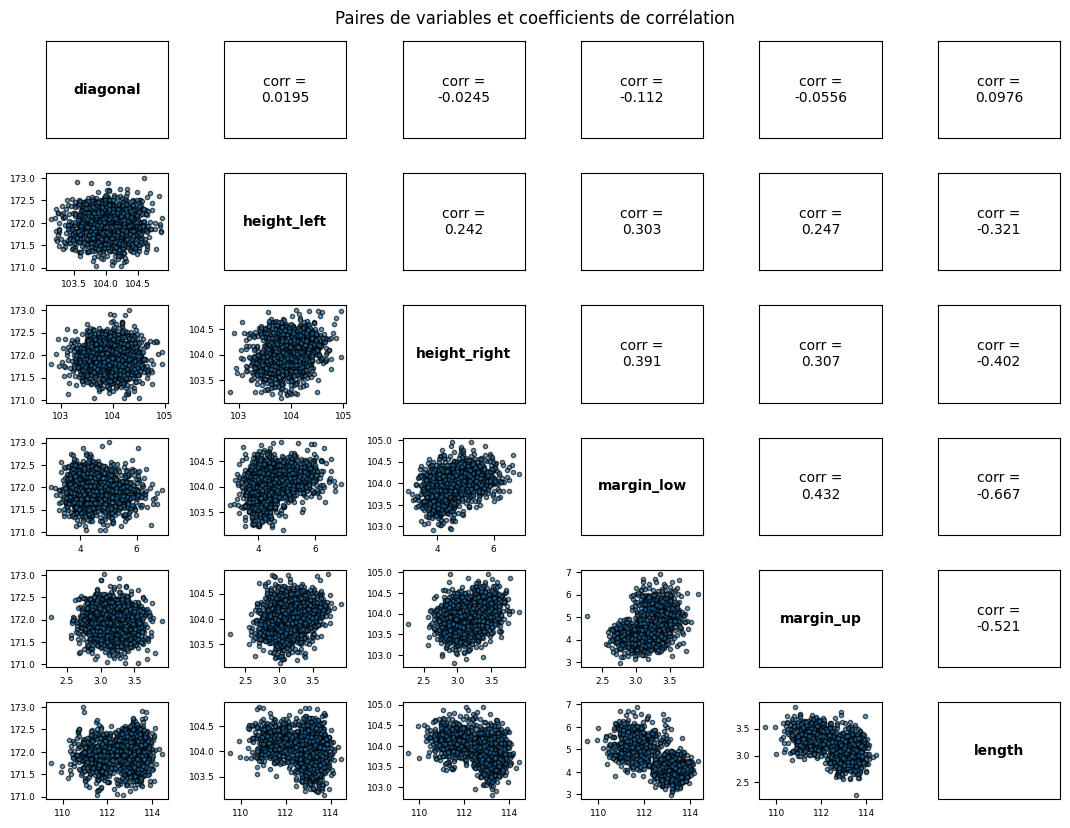

In [9]:
pairplot_correlation(df_billets, None)

* « margin_low » est dans l'ensemble plutôt bien corrélée avec les autres variables sauf avec « diagonal ». Elle est particulièrment corrélée avec « length ».
* D'autres variables explicatives sont plutôt assez corrélées entre elles, nous verrons par la suite s'il est nécessaire de toutes les conserver dans notre modèle.

### Mise en place et analyse du modèle<a id='2-2'></a>

Dans un deuxième temps, on effectue la régression grâce à `statsmodels.formula.api` et sa méthode `ols`.

La variable `formula` va nous permettre de préciser la variable dépendante ainsi que les variables explicatives. La variable dépendante est séparée de ces dernières par « ~ » et les variables explicatives sont séparées entre elles par « + ».

In [10]:
# Construit 'formula'
exog_variables = df_billets_sans_na.drop(
    columns=['is_genuine', 'margin_low']).columns

formula = ('margin_low ~ ' + ' + '.join(exog_variables))

print(f'formula : {formula}')

formula : margin_low ~ diagonal + height_left + height_right + margin_up + length


Puis on effectue la régression.

In [11]:
lr = smf.ols(formula, data=df_billets_sans_na).fit()

L'avantage de `statsmodels` est de nous fournir un rapport complet permettant de juger de la qualité de la régression.

In [12]:
# Affiche la première partie du rapport
print(lr.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 26 Sep 2023   Prob (F-statistic):          2.60e-202
Time:                        17:06:56   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         


La valeur de R²<sub>ajusté</sub> indique que notre modèle explique moyennement la variance des données mais la faible valeur de p-value nous indique qu'il reste pertinent.

In [13]:
# Affiche la seconde partie du rapport
print(lr.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374


Les différentes p-value (P>|t|) des variables indiquent qu'il est utile de toutes les conserver.

### Fiabilité du modèle<a id='2-3'></a>

Afin de nous assurer que notre modèle est fiables, il est important de vérifier que plusieurs hypothèses sont satisfaites.

#### Hypothèse 1 : linéarité du modèle

La relation entre les variables explicatives et la variable cible doit être linéaire. Pour vérifier cela, on trace les résidus en fonction des valeurs prédites et on vérifie si on observe une relation linéaire.

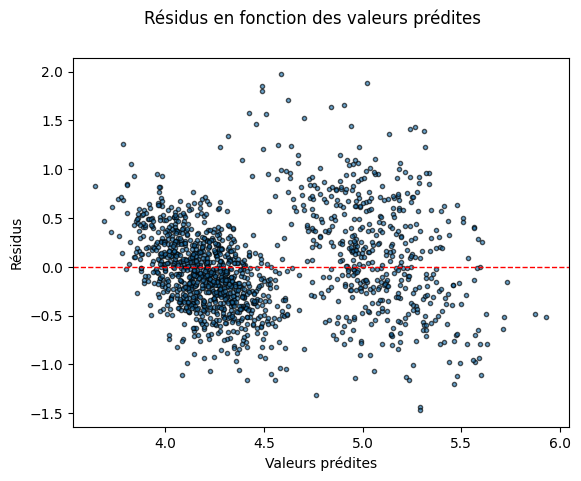

In [14]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=lr.fittedvalues, y=lr.resid, marker='.', edgecolors='k',
           alpha=0.65)
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

Dans notre cas, il ne semble pas y avoir de relation linéaire.

#### Hypothèse 2 : indépendance des résidus

Les résidus ne doivent pas être liés c’est-à-dire que la valeur d’un résidu ne doit pas nous permettre de connaître celui d’un autre. Même si cette hypothèse concerne plutôt les séries temporelles, on peut tout de même tracer les valeurs des résidus en fonction des observations.

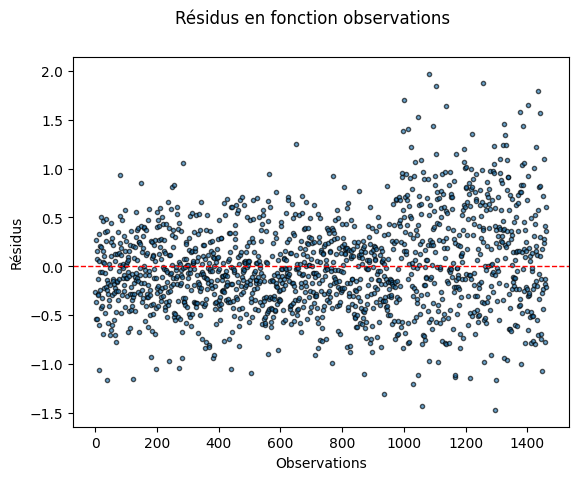

In [15]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=range(len(lr.resid)), y=lr.resid, marker='.',
           edgecolors='k', alpha=0.65)
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Observations')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction observations')

plt.show()

del fig, ax

Les résidus semblent répartis de manière aléatoire autour de 0. On observe tout de même des valeurs plus hautes à mesure que l'on avance dans les observations, mais ces dernières ne suivent pas un ordre précis.

Pour confimer notre observation, on réalise un test de Durbin-Watson. Cette statistique a une valeur comprise entre 0 et 4. Si elle est proche de zéro, l'autocorrélation est positive, les valeurs situées autour de 2 montrent une absence d’autocorrélation et si l’on s’approche de 4, il existe une autocorrélation négative. Le résultat de ce test est présent dans le rapport de `statsmodels`.

In [16]:
# Affiche la troisième partie du rapport
print(lr.summary().tables[2])

Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05


Ici la valeur est proche de 2 donc il y a indépendance des résidus.

#### Hypothèse 3 : homoscédasticité

L'homoscédasticité significie que la variance des résidus est constante. Nous avons constaté précédemment que les résidus sont dispersés de manière relativement uniforme autour de 0 donc l'homoscédasticité est probablement satisfaite. Néanmoins, nous allons réaliser le test statistique de Breush-Pagan dont les hypothèses sont les suivantes :
* H<sub>0</sub> : L’homoscédasticité est présente si p-value > 5 % ;
* H<sub>1</sub> : L’homoscédasticité n’est pas présente si p-value < 5 %.

In [17]:
# Réalise le test de Breush-Pagan
from statsmodels.stats.diagnostic import het_breuschpagan
res = het_breuschpagan(lr.resid, lr.model.exog)

print(f'Résultat du test de Breush-Pagan :\n>> p-value = {res[1]:.2e}')
if res[1] > 0.05:
    print(f'   H0 est retenue, homoscédasticité est présente.')
elif res[1] < 0.05:
    print(f'   H1 est retenue, homoscédasticité n\'est pas présente.')

del res

Résultat du test de Breush-Pagan :
>> p-value = 7.76e-16
   H1 est retenue, homoscédasticité n'est pas présente.


#### Hypothèse 4 : normalité des résidus

Les valeurs des résidus doivent suivre une loi normale. On trace la distribution des résidus.

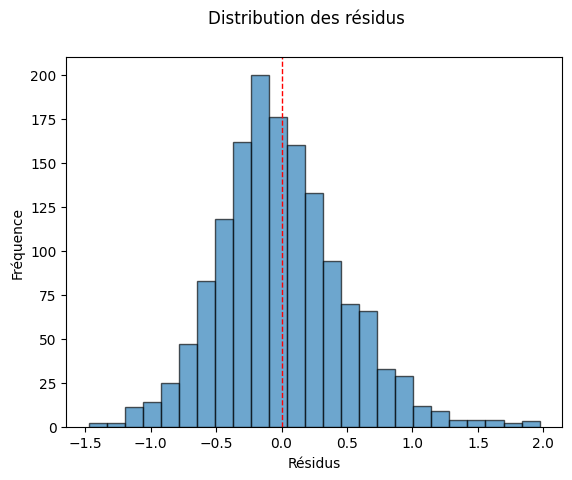

In [18]:
# Trace le graphique
fig, ax = plt.subplots()

ax.hist(x=lr.resid, bins=25, edgecolor='k', alpha=0.65)
ax.axvline(x=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
fig.suptitle('Distribution des résidus')

plt.show()

del fig, ax

On observe un décalage sur la gauche mais, à priori, la distribution semble correcte. Nous allons réaliser un test de Shapiro-Wilk ayant les hypothèses suivantes :
* H<sub>0</sub> : La normalité est vérifiée si p-value > 5 % ;
* H<sub>1</sub> : La normalité n'est pas vérifiée si p-value < 5 %.

In [19]:
# Réalise le test de Shapiro-Wilk
from scipy import stats
res = stats.shapiro(lr.resid)

print(f'Résultat du test de Shapiro-Wilk :\n>> p-value = {res.pvalue:.2e}')
if res.pvalue > 0.05:
    print(f'   H0 est retenue, la normalité est vérifiée.')
elif res.pvalue < 0.05:
    print(f'   H1 est retenue, la normalité n\'est pas vérifiée.')

del res

Résultat du test de Shapiro-Wilk :
>> p-value = 8.54e-11
   H1 est retenue, la normalité n'est pas vérifiée.


#### Hypothèse 5 : pas de colinéarité

Les variables explicatives ne doivent pas être très corrélées entre elles.

Nous avions déjà calculé les corrélations entre variables et certains coefficients semblaient élevés.

In [20]:
# Affiche la matrice de corrélation
(df_billets_sans_na.drop(columns='is_genuine').corr()
 .style.background_gradient(cmap='viridis'))

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


Pour évaluer la colinéarité, nous allons calculer le facteur d'inflation de la variance (VIF) qui mesure l'influence de la colinéarité sur la variance de nos estimations de coefficient.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

print(f'''{'Feature':<14}{'VIF':>8}''')
for i, column in enumerate(df_billets_sans_na[exog_variables].columns):
    vif = variance_inflation_factor(df_billets_sans_na[exog_variables].values, i)
    print(f'{column:<14}{round(vif):>8}')

del exog_variables, i, column, vif

Feature            VIF
diagonal        170567
height_left     111895
height_right    100859
margin_up          262
length           22708


### Prédiction des valeurs manquantes<a id='2-4'></a>

In [ ]:
# Crée une copie du DataFrame avec uniquement les valeurs manquantes
df_billets_na = df_billets.loc[df_billets.isna().any(axis='columns')].copy()

# Impute les valeurs grâce au modèle
df_billets_na['margin_low'] = lr.predict(df_billets_na)

# Concatène les DataFrames avec et sans valeurs manquantes
df_billets = pd.concat([df_billets_sans_na, df_billets_na]).sort_index()

del df_billets_sans_na, df_billets_na, formula, lr

## Analyse descriptive<a id='3'></a>

### Analyse univariée<a id='3-1'></a>

In [29]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [30]:
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


In [32]:
df_billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [33]:
# Affiche les quantités de vrais/faux billets
print(
    f'Le jeu de données comprend :\n'
    f'''- {sum(df_billets['is_genuine'] == True)} billets authentiques ;\n'''
    f'''- {sum(df_billets['is_genuine'] == False)} faux billets.'''
)

Le jeu de données comprend :
- 1000 billets authentiques ;
- 500 faux billets.


In [40]:
df_billets.groupby('is_genuine').agg('mean')

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.214079,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.118174,3.05213,113.20243
